# Detection of Exoplanets using Transit Photometry

> [Detection of exoplanets using transit photometry](http://reports.ias.ac.in/report/19120/detection-of-exoplanets-using-transit-photometry):
* __Sky Debnath__: Department of Physics, National Institute of Technology Agartala, Jirania, West Tripura, Tripura 799046
* __Avinash A Deshpande__: Astronomy and Astrophysics, Raman Research Institute, C. V. Raman Avenue, Sadashivnagar, Bengaluru 560080

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_00.gif)
[images source](https://sites.pitt.edu/~stepup/DataAnalysis.html)

Exoplanets are the planets found outside of the solar system. When a planet passes in front of a star, the brightness of that star as observed by us becomes dimmer depending on the size of the planet. The data we observe will show a dip in flux if a planet is transiting the star we are observing.

> Dataset: [Exoplanet Hunting in Deep Space](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data) - Kepler labelled time series data.

The data describe the change in flux (light intensity) of several thousand stars. Each star has a binary label of `2` or `1`. 2 indicated that that the star is confirmed to have at least one exoplanet in orbit

In [1]:
from autogluon.multimodal import MultiModalPredictor
from autogluon.tabular import TabularDataset, TabularPredictor
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')

2023-06-26 18:35:59.537905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED=42
MODEL_PATH = 'model'

## Dataset Preprocessing

In [2]:
df_train = pd.read_csv('dataset/exoTrain.csv')
df_test = pd.read_csv('dataset/exoTest.csv')

print(df_train.shape, df_test.shape)
# (5087, 3198) (570, 3198)

(5087, 3198) (570, 3198)


In [3]:
df_train.head(5).transpose()

,0,1,2,3,4
LABEL,2.00,2.00,2.00,2.00,2.00
FLUX.1,93.85,-38.88,532.64,326.52,-1107.21
FLUX.2,83.81,-33.83,535.92,347.39,-1112.59
FLUX.3,20.10,-58.54,513.73,302.35,-1118.95
FLUX.4,-26.98,-40.09,496.92,298.13,-1095.10
...,...,...,...,...,...
FLUX.3193,92.54,0.76,5.06,-12.67,-438.54
FLUX.3194,39.32,-11.70,-11.80,-8.77,-399.71
FLUX.3195,61.42,6.46,-28.91,-17.31,-384.65
FLUX.3196,5.08,16.00,-70.02,-17.35,-411.79


|  | 0 | 1 | 2 | 3 | 4 |
| -- | -- | -- | -- | -- | -- |
| LABEL | 2.00 | 2.00 | 2.00 | 2.00 | 2.00 |
| FLUX.1 | 93.85 | -38.88 | 532.64 | 326.52 | -1107.21 |
| FLUX.2 | 83.81 | -33.83 | 535.92 | 347.39 | -1112.59 |
| FLUX.3 | 20.10 | -58.54 | 513.73 | 302.35 | -1118.95 |
| FLUX.4 | -26.98 | -40.09 | 496.92 | 298.13 | -1095.10 |
| ... |
| FLUX.3193 | 92.54 | 0.76 | 5.06 | -12.67 | -438.54 |
| FLUX.3194 | 39.32 | -11.70 | -11.80 | -8.77 | -399.71 |
| FLUX.3195 | 61.42 | 6.46 | -28.91 | -17.31 | -384.65 |
| FLUX.3196 | 5.08 | 16.00 | -70.02 | -17.35 | -411.79 |
| FLUX.3197 | -39.54 | 19.93 | -96.67 | 13.98 | -510.54 |

In [4]:
# replacing label class [1,2] -> [0,1]
df_train = df_train.replace({'LABEL': {2:1, 1:0}})
df_test = df_test.replace({'LABEL': {2:1, 1:0}})

### Missing Values

0


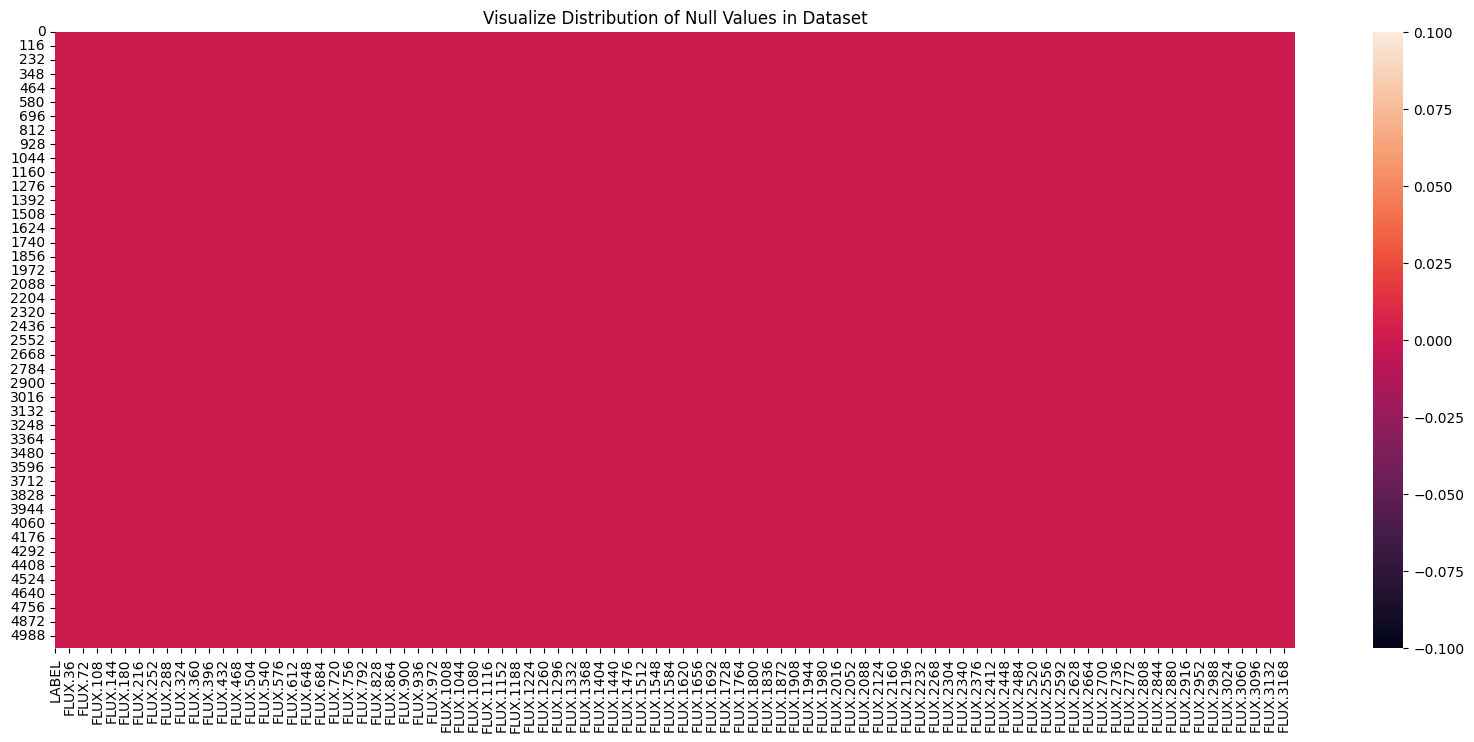

In [4]:
# how many values are missing?
print(df_train.isnull().sum().sum())
# 0 => no missing data
plt.figure(figsize=(20, 8))
plt.title('Visualize Distribution of Null Values in Dataset')

sns.heatmap(
    df_train.isnull(),
    annot=False
)

plt.savefig('assets/Real_World_Model_to_Deployment_01.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_01.webp)

### Label Imbalance

In [5]:
# is the dataset balanced?
df_train['LABEL'].value_counts()

# the dataset only has 37 positives against 5050 negatives
# 0    5050
# 1      37
# Name: LABEL, dtype: int64

0    5050
1      37
Name: LABEL, dtype: int64

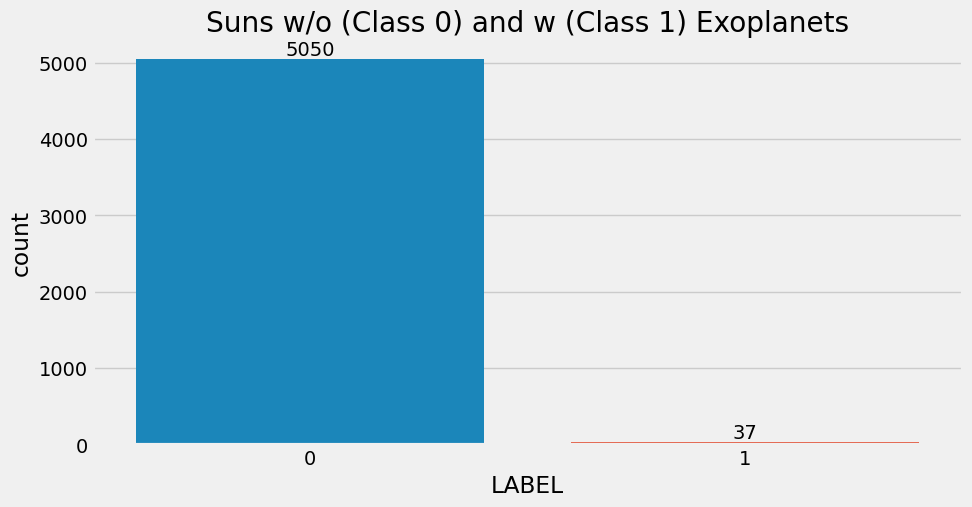

In [12]:
plt.figure(figsize=(10, 5))
plt.title('Suns w/o (Class 0) and w (Class 1) Exoplanets')

ax = sns.countplot(
    data=df_train,
    x='LABEL'
)

ax.bar_label(ax.containers[0])

plt.savefig('assets/Real_World_Model_to_Deployment_02.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_02.webp)

In [6]:
exoplanets = df_train[df_train['LABEL'] == 1.]
exoplanets

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,1,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,1,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,1,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,1,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,1,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


|    | LABEL | FLUX.1 | FLUX.2 | FLUX.3 | FLUX.4 | FLUX.5 | FLUX.6 | FLUX.7 | FLUX.8 | FLUX.9 | ... | FLUX.3188 | FLUX.3189 | FLUX.3190 | FLUX.3191 | FLUX.3192 | FLUX.3193 | FLUX.3194 | FLUX.3195 | FLUX.3196 | FLUX.3197 |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | 1 | 93.85 | 83.81 | 20.10 | -26.98 | -39.56 | -124.71 | -135.18 | -96.27 | -79.89 | ... | -78.07 | -102.15 | -102.15 | 25.13 | 48.57 | 92.54 | 39.32 | 61.42 | 5.08 | -39.54 |
| 1 | 1 | -38.88 | -33.83 | -58.54 | -40.09 | -79.31 | -72.81 | -86.55 | -85.33 | -83.97 | ... | -3.28 | -32.21 | -32.21 | -24.89 | -4.86 | 0.76 | -11.70 | 6.46 | 16.00 | 19.93 |
| 2 | 1 | 532.64 | 535.92 | 513.73 | 496.92 | 456.45 | 466.00 | 464.50 | 486.39 | 436.56 | ... | -71.69 | 13.31 | 13.31 | -29.89 | -20.88 | 5.06 | -11.80 | -28.91 | -70.02 | -96.67 |
| 3 | 1 | 326.52 | 347.39 | 302.35 | 298.13 | 317.74 | 312.70 | 322.33 | 311.31 | 312.42 | ... | 5.71 | -3.73 | -3.73 | 30.05 | 20.03 | -12.67 | -8.77 | -17.31 | -17.35 | 13.98 |
| 4 | 1 | -1107.21 | -1112.59 | -1118.95 | -1095.10 | -1057.55 | -1034.48 | -998.34 | -1022.71 | -989.57 | ... | -594.37 | -401.66 | -401.66 | -357.24 | -443.76 | -438.54 | -399.71 | -384.65 | -411.79 | -510.54 |
| 5 | 1 | 211.10 | 163.57 | 179.16 | 187.82 | 188.46 | 168.13 | 203.46 | 178.65 | 166.49 | ... | -98.45 | 30.34 | 30.34 | 29.62 | 28.80 | 19.27 | -43.90 | -41.63 | -52.90 | -16.16 |
| 6 | 1 | 9.34 | 49.96 | 33.30 | 9.63 | 37.64 | 20.85 | 4.54 | 22.42 | 10.11 | ... | -58.56 | 9.93 | 9.93 | 23.50 | 5.28 | -0.44 | 10.90 | -11.77 | -9.25 | -36.69 |
| 7 | 1 | 238.77 | 262.16 | 277.80 | 190.16 | 180.98 | 123.27 | 103.95 | 50.70 | 59.91 | ... | -72.48 | 31.77 | 31.77 | 53.48 | 27.88 | 95.30 | 48.86 | -10.62 | -112.02 | -229.92 |
| 8 | 1 | -103.54 | -118.97 | -108.93 | -72.25 | -61.46 | -50.16 | -20.61 | -12.44 | 1.48 | ... | 43.92 | 7.24 | 7.24 | -7.45 | -18.82 | 4.53 | 21.95 | 26.94 | 34.08 | 44.65 |
| 9 | 1 | -265.91 | -318.59 | -335.66 | -450.47 | -453.09 | -561.47 | -606.03 | -712.72 | -685.97 | ... | 3671.03 | 2249.28 | 2249.28 | 2437.78 | 2584.22 | 3162.53 | 3398.28 | 3648.34 | 3671.97 | 3781.91 |
| 10 | 1 | 118.81 | 110.97 | 79.53 | 114.25 | 48.78 | 3.12 | -4.09 | 66.20 | -26.02 | ... | 50.05 | 50.05 | 50.05 | 67.42 | -56.78 | 126.14 | 200.36 | 432.95 | 721.81 | 938.08 |
| 11 | 1 | -239.88 | -164.28 | -180.91 | -225.69 | -90.66 | -130.66 | -149.75 | -120.50 | -157.00 | ... | -364.75 | -364.75 | -364.75 | -196.38 | -165.81 | -215.94 | -293.25 | -214.34 | -154.84 | -151.41 |
| 12 | 1 | 70.34 | 63.86 | 58.37 | 69.43 | 64.18 | 52.70 | 47.58 | 46.89 | 46.00 | ... | 6.45 | -8.91 | -8.91 | -6.70 | -5.04 | -10.79 | -4.97 | -7.46 | -15.06 | -2.06 |
| 13 | 1 | 424.14 | 407.71 | 461.59 | 428.17 | 412.69 | 395.58 | 453.35 | 410.45 | 402.09 | ... | 238.36 | 46.65 | 46.65 | 95.90 | 123.48 | 138.38 | 190.66 | 202.55 | 232.16 | 251.73 |
| 14 | 1 | -267.21 | -239.11 | -233.15 | -211.84 | -191.56 | -181.69 | -164.77 | -156.68 | -139.23 | ... | -754.92 | -752.38 | -752.38 | -754.93 | -761.64 | -746.83 | -765.22 | -757.05 | -763.26 | -769.39 |
| 15 | 1 | 35.92 | 45.84 | 47.99 | 74.58 | 87.97 | 87.97 | 105.23 | 131.70 | 130.00 | ... | 39.71 | -2.53 | -2.53 | 15.32 | 18.65 | 20.43 | 22.40 | 37.32 | 36.01 | 71.59 |
| 16 | 1 | -122.30 | -122.30 | -131.08 | -109.69 | -109.69 | -95.27 | -93.93 | -84.84 | -73.65 | ... | 22.64 | -42.53 | -42.53 | -46.43 | -56.26 | -54.25 | -37.13 | -24.73 | 13.35 | -5.81 |
| 17 | 1 | -65.20 | -76.33 | -76.23 | -72.58 | -69.62 | -74.51 | -69.48 | -61.06 | -49.29 | ... | 18.66 | -11.72 | -11.72 | 4.56 | 11.47 | 31.26 | 21.71 | 13.42 | 13.24 | 9.21 |
| 18 | 1 | -66.47 | -15.50 | -44.59 | -49.03 | -70.16 | -85.53 | -52.06 | -73.41 | -59.69 | ... | -6.19 | 10.00 | 10.00 | 50.12 | -14.97 | -32.75 | -30.28 | -9.28 | -31.53 | 26.88 |
| 19 | 1 | 560.19 | 262.94 | 189.94 | 185.12 | 210.38 | 104.19 | 289.56 | 172.06 | 81.75 | ... | 106.00 | -7.94 | -7.94 | -7.94 | 52.31 | -165.00 | 7.38 | -61.56 | -44.75 | 104.50 |
| 20 | 1 | -1831.31 | -1781.44 | -1930.84 | -2016.72 | -1963.31 | -1956.12 | -2128.24 | -2188.20 | -2212.82 | ... | 903.82 | 75.61 | 75.61 | 191.77 | 196.16 | 326.61 | 481.28 | 635.63 | 651.68 | 695.74 |
| 21 | 1 | 2053.62 | 2126.05 | 2146.33 | 2159.84 | 2237.59 | 2236.12 | 2244.47 | 2279.61 | 2288.22 | ... | 1832.59 | 1935.53 | 1965.84 | 2094.19 | 2212.52 | 2292.64 | 2454.48 | 2568.16 | 2625.45 | 2578.80 |
| 22 | 1 | -48.48 | -22.95 | 11.15 | -70.04 | -120.34 | -150.04 | -309.38 | -160.73 | -201.41 | ... | 90.70 | -20.01 | -62.12 | -45.96 | -52.40 | -4.93 | 26.74 | 21.43 | 145.30 | 197.20 |
| 23 | 1 | 145.84 | 137.82 | 96.99 | 17.09 | -73.79 | -157.79 | -267.71 | -365.91 | -385.07 | ... | 62.76 | 101.24 | 98.13 | 112.51 | 95.77 | 127.98 | 67.51 | 91.24 | 40.40 | -10.80 |
| 24 | 1 | 207.37 | 195.04 | 150.45 | 135.34 | 104.90 | 59.79 | 42.85 | 52.74 | 18.38 | ... | -13.21 | -43.43 | -14.77 | -22.27 | -0.04 | 19.46 | 9.32 | 23.55 | -4.73 | 11.82 |
| 25 | 1 | 304.50 | 275.94 | 269.24 | 248.51 | 194.88 | 167.80 | 139.13 | 149.36 | 100.97 | ... | 4.21 | 3.53 | -5.13 | 14.56 | -1.44 | -10.73 | 3.49 | 0.18 | -2.89 | 40.34 |
| 26 | 1 | 150725.80 | 129578.36 | 102184.98 | 82253.98 | 67934.17 | 48063.52 | 42745.02 | 18971.55 | 2983.58 | ... | -11143.45 | -23351.45 | -33590.27 | -31861.95 | -23298.89 | -13056.11 | 379.48 | 9444.52 | 23261.02 | 33565.48 |
| 27 | 1 | 124.39 | 72.73 | 36.85 | -4.68 | 6.96 | -44.61 | -89.79 | -121.71 | -120.59 | ... | -14.38 | -21.65 | -6.04 | -7.15 | 67.58 | 56.43 | -1.95 | 7.09 | 1.63 | -10.77 |
| 28 | 1 | -63.50 | -49.15 | -45.99 | -34.55 | -44.34 | -15.80 | -16.07 | 5.32 | -7.05 | ... | -113.73 | -113.58 | -130.99 | -121.51 | -94.69 | -90.38 | -74.36 | -56.49 | -46.51 | -44.53 |
| 29 | 1 | 31.29 | 25.14 | 36.93 | 16.63 | 17.01 | -7.50 | 0.09 | 1.24 | -19.82 | ... | 11.36 | 12.96 | 28.50 | 51.05 | 25.85 | 4.79 | 13.26 | -17.58 | 13.79 | 0.72 |
| 30 | 1 | -472.50 | -384.09 | -330.42 | -273.41 | -185.02 | -115.64 | -141.86 | -16.23 | 77.80 | ... | -3408.88 | -3425.92 | -3465.59 | -3422.95 | -3398.83 | -3410.42 | -3393.58 | -3407.78 | -3391.56 | -3397.03 |
| 31 | 1 | 194.82 | 162.51 | 126.17 | 129.70 | 82.27 | 60.71 | 58.71 | 23.36 | 32.57 | ... | 29.21 | 47.66 | 0.48 | -28.59 | -33.15 | -14.98 | -1.56 | 22.25 | 21.55 | 3.49 |
| 32 | 1 | 26.96 | 38.98 | 25.99 | 47.28 | 26.29 | 34.08 | 16.66 | 28.27 | 20.99 | ... | 35.26 | -9.94 | 23.73 | -7.54 | -5.86 | 13.04 | -5.64 | -16.85 | -6.18 | -16.03 |
| 33 | 1 | 43.07 | 46.73 | 29.43 | 9.75 | 6.54 | -3.76 | -31.48 | -46.94 | -40.78 | ... | 6.99 | 5.75 | 23.18 | 15.08 | 18.09 | 13.40 | 15.78 | 18.18 | 51.21 | 9.71 |
| 34 | 1 | -248.23 | -243.59 | -217.91 | -190.69 | -190.17 | -163.04 | -196.32 | -164.73 | -149.34 | ... | 94.25 | 121.45 | 135.02 | 147.14 | 161.89 | 198.05 | 262.03 | 282.88 | 334.81 | 377.14 |
| 35 | 1 | 22.82 | 46.37 | 39.61 | 98.75 | 81.32 | 100.43 | 65.00 | 38.86 | 22.11 | ... | 55.50 | -16.22 | -5.21 | 15.04 | 11.86 | -5.38 | -24.46 | -55.86 | -44.55 | -16.80 |
| 36 | 1 | 26.24 | 42.32 | 28.34 | 24.81 | 49.39 | 47.57 | 41.52 | 51.80 | 25.50 | ... | -7.53 | -35.72 | -14.32 | -29.21 | -30.61 | 8.49 | 4.75 | 6.59 | -7.03 | 24.41 |

_37 rows × 3198 columns_

### Visualizing Differences between both Classes

In [7]:
# separate label
X_train = df_train.drop(['LABEL'], axis=1)
y_train = df_train['LABEL']
X_test = df_test.drop(['LABEL'], axis=1)
y_test = df_test['LABEL']

In [11]:
# plot light curve for a single sun
## there are no timestamp -> generate range
time = range(1,3198)
## get brightness values for suns (class 0)
flux_00 = X_train.iloc[444,:].values
flux_01 = X_train.iloc[222,:].values
flux_02 = X_train.iloc[666,:].values
flux_03 = X_train.iloc[888,:].values
flux_04 = X_train.iloc[111,:].values
flux_05 = X_train.iloc[5000,:].values
## get brightness values for suns (class 1)
flux_10 = X_train.iloc[0,:].values
flux_11 = X_train.iloc[5,:].values
flux_12 = X_train.iloc[11,:].values
flux_13 = X_train.iloc[17,:].values
flux_14 = X_train.iloc[23,:].values
flux_15 = X_train.iloc[29,:].values

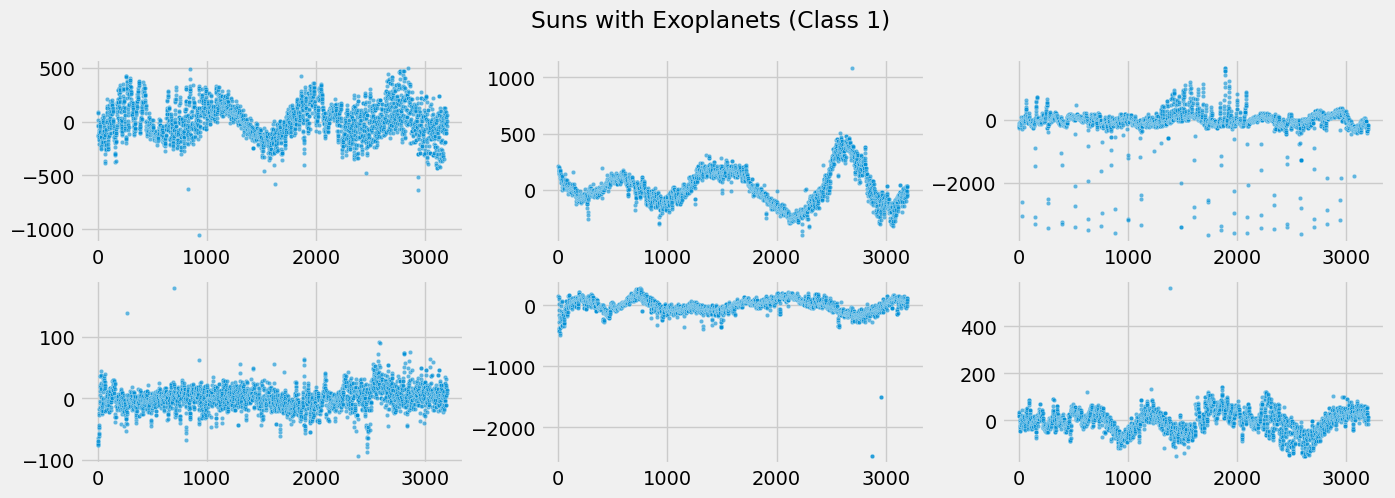

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
fig.suptitle('Suns with Exoplanets (Class 1)')

sns.scatterplot(
    x=time,
    y=flux_10,
    s=10,
    alpha=0.6,
    ax=axes[0,0]
)

sns.scatterplot(
    x=time,
    y=flux_11,
    s=10,
    alpha=0.6,
    ax=axes[0,1]
)

sns.scatterplot(
    x=time,
    y=flux_12,
    s=10,
    alpha=0.6,
    ax=axes[0,2]
)

sns.scatterplot(
    x=time,
    y=flux_13,
    s=10,
    alpha=0.6,
    ax=axes[1,0]
)

sns.scatterplot(
    x=time,
    y=flux_14,
    s=10,
    alpha=0.6,
    ax=axes[1,1]
)

sns.scatterplot(
    x=time,
    y=flux_15,
    s=10,
    alpha=0.6,
    ax=axes[1,2]
)

plt.savefig('assets/Real_World_Model_to_Deployment_03.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_03.webp)

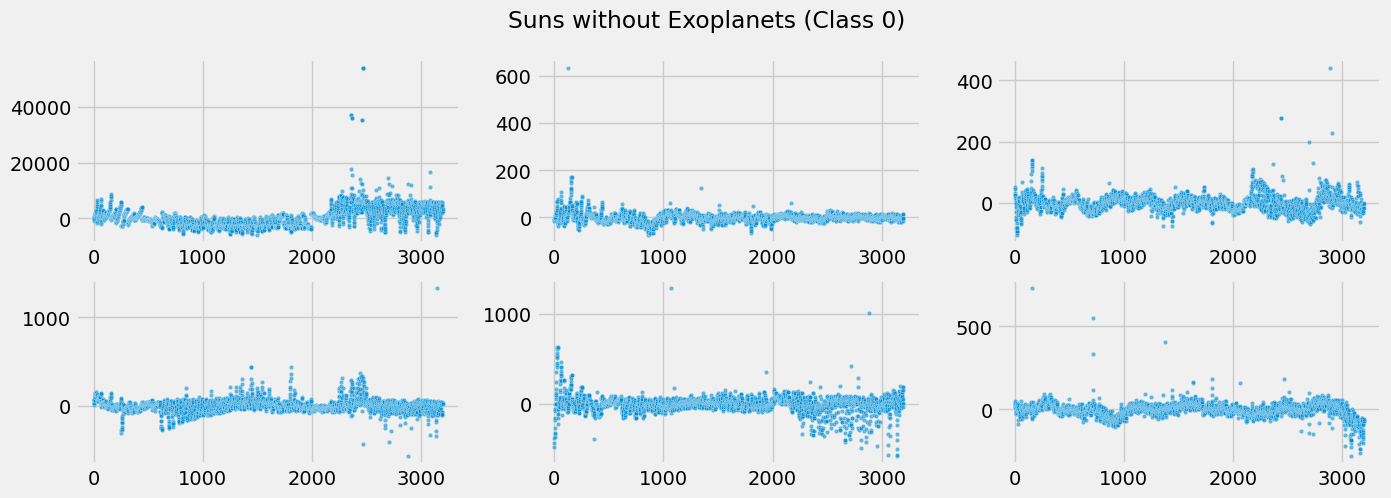

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
fig.suptitle('Suns without Exoplanets (Class 0)')

sns.scatterplot(
    x=time,
    y=flux_00,
    s=10,
    alpha=0.6,
    ax=axes[0,0]
)

sns.scatterplot(
    x=time,
    y=flux_01,
    s=10,
    alpha=0.6,
    ax=axes[0,1]
)

sns.scatterplot(
    x=time,
    y=flux_02,
    s=10,
    alpha=0.6,
    ax=axes[0,2]
)

sns.scatterplot(
    x=time,
    y=flux_03,
    s=10,
    alpha=0.6,
    ax=axes[1,0]
)

sns.scatterplot(
    x=time,
    y=flux_04,
    s=10,
    alpha=0.6,
    ax=axes[1,1]
)

sns.scatterplot(
    x=time,
    y=flux_05,
    s=10,
    alpha=0.6,
    ax=axes[1,2]
)

plt.savefig('assets/Real_World_Model_to_Deployment_04.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_04.webp)

### Handling Outliers

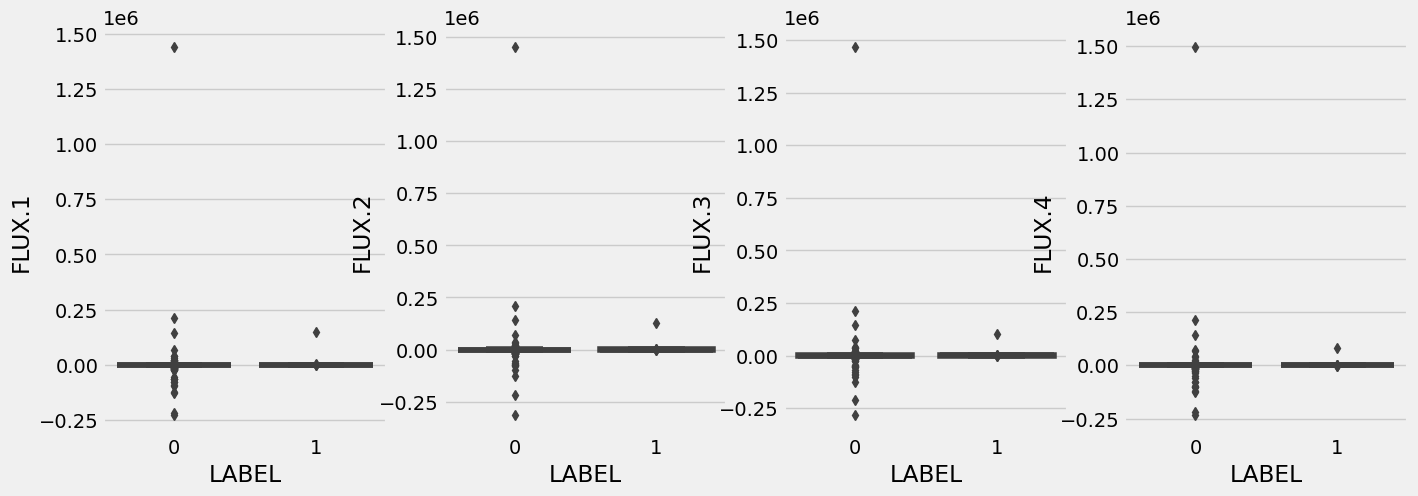

In [15]:
plt.figure(figsize=(15, 5))

for i in range(1,5):
    plt.subplot(1,4,i)
    sns.boxplot(data=df_train, x='LABEL', y='FLUX.' + str(i))

plt.savefig('assets/Real_World_Model_to_Deployment_05.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_05.webp)

In [16]:
# there is one extreme outlier with a value above 0.25e6 in FLUX.1
df_train[df_train['FLUX.1'] > 0.25e6].index
# Int64Index([3340], dtype='int64')

Int64Index([3340], dtype='int64')

In [17]:
df_train[df_train['FLUX.3'] > 0.25e6].index
# Int64Index([3340], dtype='int64')

Int64Index([3340], dtype='int64')

In [18]:
# it is the same sun in both cases with iloc 3340 -> drop
df_train = df_train.drop(3340, axis=0)

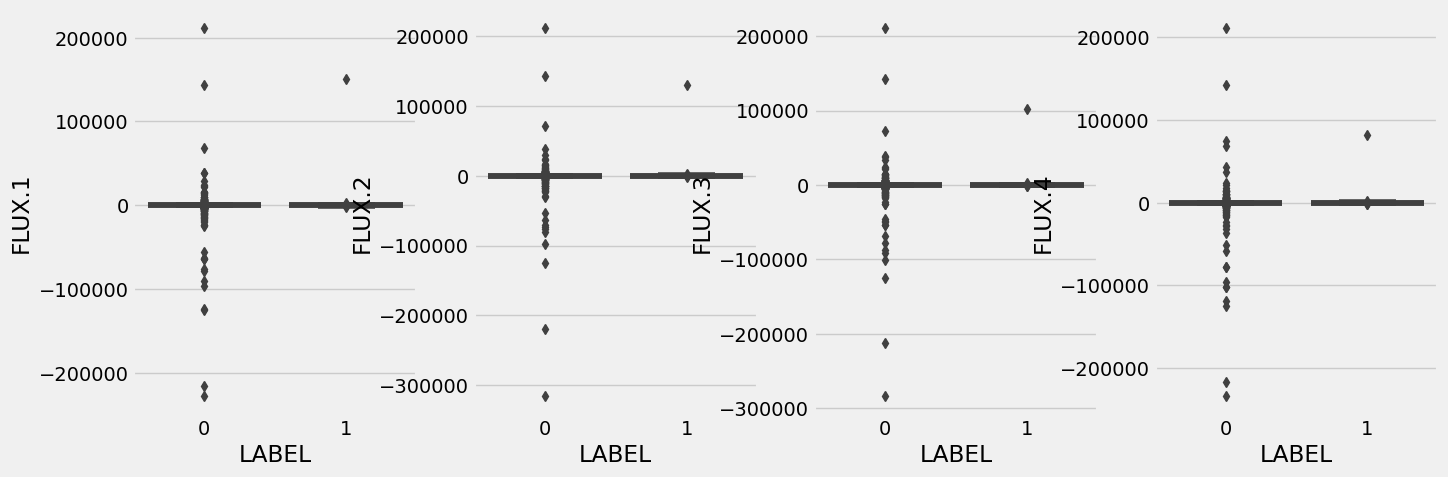

In [19]:
plt.figure(figsize=(15, 5))

for i in range(1,5):
    plt.subplot(1,4,i)
    sns.boxplot(data=df_train, x='LABEL', y='FLUX.' + str(i))

plt.savefig('assets/Real_World_Model_to_Deployment_06.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_06.webp)

## Model Training

In [23]:
# the dataset is already split into train/test -> further split validation from train set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=SEED
)

In [24]:
X_train.shape, X_val.shape
# ((3560, 3197), (1527, 3197))

((3560, 3197), (1527, 3197))

In [26]:
# normalizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

### KNN Model on Imbalanced Datasets

In [31]:
knn_classifier = KNC(n_neighbors=5, metric='minkowski', p=2)

knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

### Model Evaluation

In [33]:
y_pred = knn_classifier.predict(X_val)
print(accuracy_score(y_pred, y_val))
# 0.9921414538310412
print(classification_report(y_val, y_pred))
# the imbalanced dataset leads to spectacular accuracies, but...

/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9921414538310412
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1515
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1527
   macro avg       0.50      0.50      0.50      1527
weighted avg       0.98      0.99      0.99      1527



/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|    |   precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
|      0   |  0.99 | 1.00 | 1.00 | 1515 |
|      1   |  0.00 | 0.00 | 0.00 |   12 |
|     accuracy |       |      | 0.99 | 1527 |
|    macro avg |  0.50 | 0.50 | 0.50 | 1527 |
| weighted avg |  0.98 | 0.99 | 0.99 | 1527 |

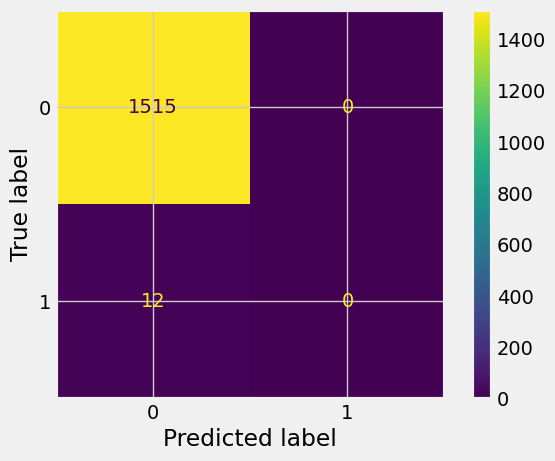

In [37]:
# because there are so few positives in the dataset
# the accuracy is not affected by a 100% fail in detection
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred)
).plot()

plt.savefig('assets/Real_World_Model_to_Deployment_07.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_07.webp)

### Random Oversampling to balance the Dataset 

In [40]:
# get full training dataset again
X_train = df_train.drop(['LABEL'], axis=1)
y_train = df_train['LABEL']

In [41]:
over_sampler = RandomOverSampler()

x_osample, y_osample =over_sampler.fit_resample(X_train, y_train)

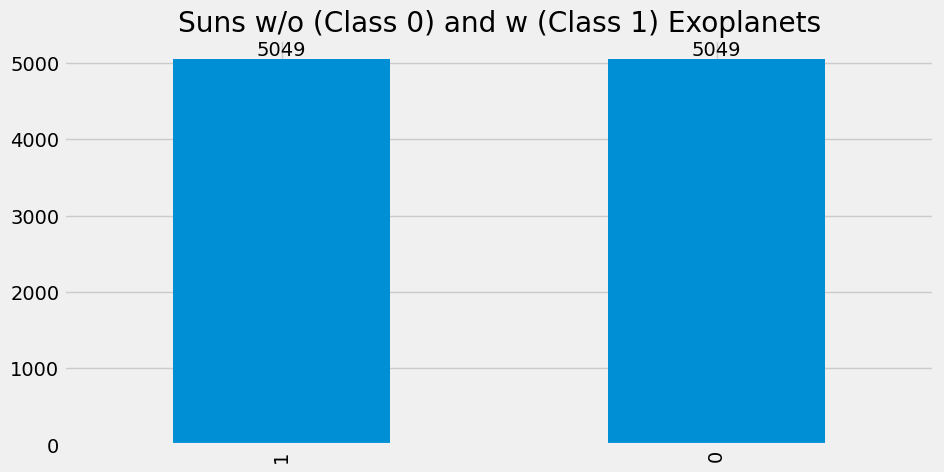

In [57]:
plt.figure(figsize=(10, 5))
plt.title('Suns w/o (Class 0) and w (Class 1) Exoplanets')

ax = y_osample.value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])

plt.savefig('assets/Real_World_Model_to_Deployment_08.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_08.webp)

### KNN Model on the balanced Data

In [59]:
# the dataset is already split into train/test -> further split validation from train set
X_train, X_val, y_train, y_val = train_test_split(
    x_osample, y_osample, test_size=0.3, random_state=SEED
)

In [60]:
X_train.shape, X_val.shape
# ((7068, 3197), (3030, 3197))

((7068, 3197), (3030, 3197))

In [61]:
# normalizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [62]:
knn_classifier = KNC(n_neighbors=5, metric='minkowski', p=2)

knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

### Model Evaluation

In [63]:
y_pred = knn_classifier.predict(X_val)
print(accuracy_score(y_pred, y_val))
# 0.6026402640264027
print(classification_report(y_val, y_pred))

/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.6026402640264027
              precision    recall  f1-score   support

           0       0.57      0.94      0.71      1558
           1       0.80      0.24      0.37      1472

    accuracy                           0.60      3030
   macro avg       0.68      0.59      0.54      3030
weighted avg       0.68      0.60      0.55      3030



|    |   precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
|      0   |  0.57 | 0.94 | 0.71 | 1558 |
|      1   |  0.80 | 0.24 | 0.37 |   1472 |
|     accuracy |       |      | 0.60 | 3030 |
|    macro avg |  0.68 | 0.59 | 0.54 | 3030 |
| weighted avg |  0.68 | 0.60 | 0.55 | 3030 |

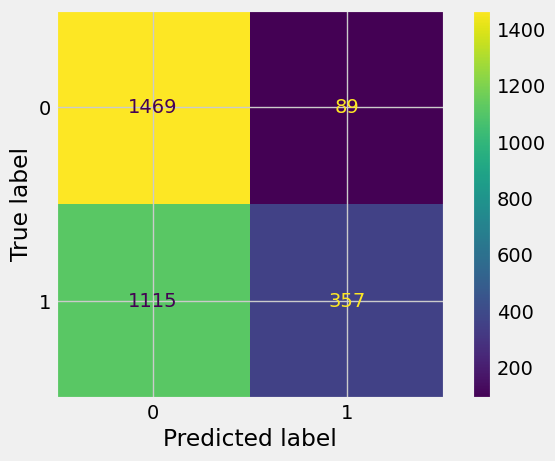

In [64]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred)
).plot()

plt.savefig('assets/Real_World_Model_to_Deployment_09.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_09.webp)

### Hyper Parameter Tuning

In [65]:
knn_classifier = KNC()

In [83]:
param_grid = {
    'n_neighbors': [4, 5, 6],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(
    estimator = knn_classifier,
    param_grid = param_grid
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [4, 5, 6], 'p': [1, 2]})

In [84]:
print('Best Parameter: ', grid_search.best_params_)
# Best Parameter:  {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}

Best Parameter:  {'n_neighbors': 4, 'p': 2}


In [87]:
# re-run training with new
knn_classifier = KNC(n_neighbors=4, metric='minkowski', p=2, weights='uniform')
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=4)

In [88]:
y_pred = knn_classifier.predict(X_val)
print(accuracy_score(y_pred, y_val))
# 0.5712871287128712
print(classification_report(y_val, y_pred))

/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.5712871287128712
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      1558
           1       0.81      0.15      0.26      1472

    accuracy                           0.57      3030
   macro avg       0.68      0.56      0.48      3030
weighted avg       0.67      0.57      0.49      3030



|    |   precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
|      0   |  0.55 | 0.96 | 0.70 | 1558 |
|      1   |  0.81 | 0.15 | 0.26 |   1472 |
|     accuracy |       |      | 0.57 | 3030 |
|    macro avg |  0.68 | 0.56 | 0.48 | 3030 |
| weighted avg |  0.67 | 0.57 | 0.49 | 3030 |

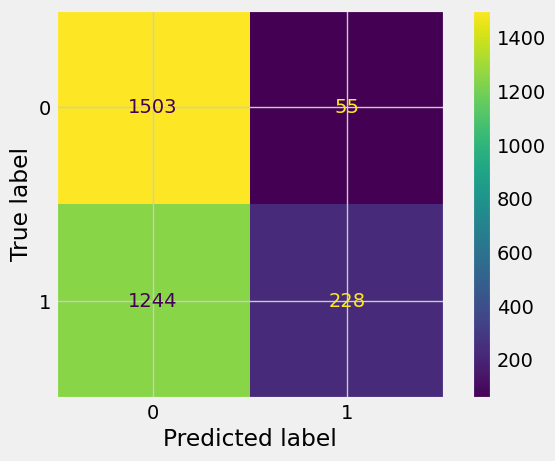

In [89]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred)
).plot()

plt.savefig('assets/Real_World_Model_to_Deployment_10.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_10.webp)

## AutoML with AutoGluon

### Tabular Data Predictor on the unbalanced Dataset

#### Data Preprocessing

In [6]:
data = TabularDataset('dataset/exoTrain.csv')
# replacing label class [1,2] -> [0,1]
data = data.replace({'LABEL': {2:1, 1:0}})
data.head(5).transpose()

,0,1,2,3,4
LABEL,1.00,1.00,1.00,1.00,1.00
FLUX.1,93.85,-38.88,532.64,326.52,-1107.21
FLUX.2,83.81,-33.83,535.92,347.39,-1112.59
FLUX.3,20.10,-58.54,513.73,302.35,-1118.95
FLUX.4,-26.98,-40.09,496.92,298.13,-1095.10
...,...,...,...,...,...
FLUX.3193,92.54,0.76,5.06,-12.67,-438.54
FLUX.3194,39.32,-11.70,-11.80,-8.77,-399.71
FLUX.3195,61.42,6.46,-28.91,-17.31,-384.65
FLUX.3196,5.08,16.00,-70.02,-17.35,-411.79


|  | 0 | 1 | 2 | 3 | 4 |
| -- | -- | -- | -- | -- | -- |
| LABEL | 1.00 | 1.00 | 1.00 | 1.00 | 1.00 |
| FLUX.1 | 93.85 | -38.88 | 532.64 | 326.52 | -1107.21 |
| FLUX.2 | 83.81 | -33.83 | 535.92 | 347.39 | -1112.59 |
| FLUX.3 | 20.10 | -58.54 | 513.73 | 302.35 | -1118.95 |
| FLUX.4 | -26.98 | -40.09 | 496.92 | 298.13 | -1095.10 |
| ... |
| FLUX.3193 | 92.54 | 0.76 | 5.06 | -12.67 | -438.54 |
| FLUX.3194 | 39.32 | -11.70 | -11.80 | -8.77 | -399.71 |
| FLUX.3195 | 61.42 | 6.46 | -28.91 | -17.31 | -384.65 |
| FLUX.3196 | 5.08 | 16.00 | -70.02 | -17.35 | -411.79 |
| FLUX.3197 | -39.54 | 19.93 | -96.67 | 13.98 | -510.54 |

In [5]:
# train/test split
print(len(data)*0.8)
# 4069.6

4069.6000000000004


In [8]:
train_size = 4070
train_data = data.sample(n=train_size, random_state=SEED)
test_data = data.drop(train_data.index)
print(len(train_data), len(test_data))
# 4070 1017

4070 1017


#### Model Training

In [9]:
predictor = TabularPredictor(label='LABEL', path=MODEL_PATH)
predictor.fit(train_data)

# AutoGluon training complete, total runtime = 315.97s ... Best model: "WeightedEnsemble_L2"

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "model/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue May 30 23:14:35 UTC 2023
Disk Space Avail:   64.34 GB / 500.10 GB (12.9%)
Train Data Rows:    4070
Train Data Columns: 3197
Label Column: LABEL
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using

In [10]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            LightGBMXT      0.992       0.020418  15.344224                0.020418          15.344224            1       True          3
1         LightGBMLarge      0.992       0.022831  71.049574                0.022831          71.049574            1       True         13
2   WeightedEnsemble_L2      0.992       0.023695  71.592278                0.000864           0.542703            2       True         14
3              LightGBM      0.992       0.025427  20.643771                0.025427          20.643771            1       True          4
4              CatBoost      0.992       0.050176  70.539329                0.050176          70.539329            1       True          7
5       NeuralNetFastAI      0.992       0.050670   9.314951                0.050670           9.314951 

/home/xiaodie/.local/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.992,
  'KNeighborsDist': 0.992,
  'LightGBMXT': 0.992,
  'LightGBM': 0.992,
  'RandomForestGini': 0.992,
  'RandomForestEntr': 0.992,
  'CatBoost': 0.992,
  'ExtraTreesGini': 0.992,
  'ExtraTreesEntr': 0.992,
  'NeuralNetFastAI': 0.992,
  'XGBoost': 0.992,
  'NeuralNetTorch': 0.992,
  'LightGBMLarge': 0.992,
  'WeightedEnsemble_L2': 0.992},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': 'model/models/KNeighborsUnif/',
  'KNeighbo

|  | model | score_val | pred_time_val | fit_time |
| -- | -- | -- | -- | -- |
| 0 | LightGBMXT | 0.992 | 0.020418 | 15.344224 |
| 1 | LightGBMLarge | 0.992 | 0.022831 | 71.049574 |
| 2 | WeightedEnsemble_L2 | 0.992 | 0.023695 | 71.592278 |
| 3 | LightGBM | 0.992 | 0.025427 | 20.643771 |
| 4 | CatBoost | 0.992 | 0.050176 | 70.539329 |
| 5 | NeuralNetFastAI | 0.992 | 0.050670 | 9.314951 |
| 6 | ExtraTreesGini | 0.992 | 0.057889 | 1.999989 |
| 7 | ExtraTreesEntr | 0.992 | 0.059487 | 2.002087 |
| 8 | RandomForestEntr | 0.992 | 0.059567 | 4.198627 |
| 9 | RandomForestGini | 0.992 | 0.062586 | 4.663457 |
| 10 | XGBoost | 0.992 | 0.064399 | 52.430401 |
| 11 | KNeighborsDist | 0.992 | 0.112409 | 0.698705 |
| 12 | KNeighborsUnif | 0.992 | 0.213056 | 0.924304 |
| 13 | NeuralNetTorch | 0.992 | 1.411860 | 52.091543 |

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            LightGBMXT      0.992       0.020418  15.344224                0.020418          15.344224            1       True          3
1         LightGBMLarge      0.992       0.022831  71.049574                0.022831          71.049574            1       True         13
2   WeightedEnsemble_L2      0.992       0.023695  71.592278                0.000864           0.542703            2       True         14
3              LightGBM      0.992       0.025427  20.643771                0.025427          20.643771            1       True          4
4              CatBoost      0.992       0.050176  70.539329                0.050176          70.539329            1       True          7
5       NeuralNetFastAI      0.992       0.050670   9.314951                0.050670           9.314951            1       True         10
6        ExtraTreesGini    

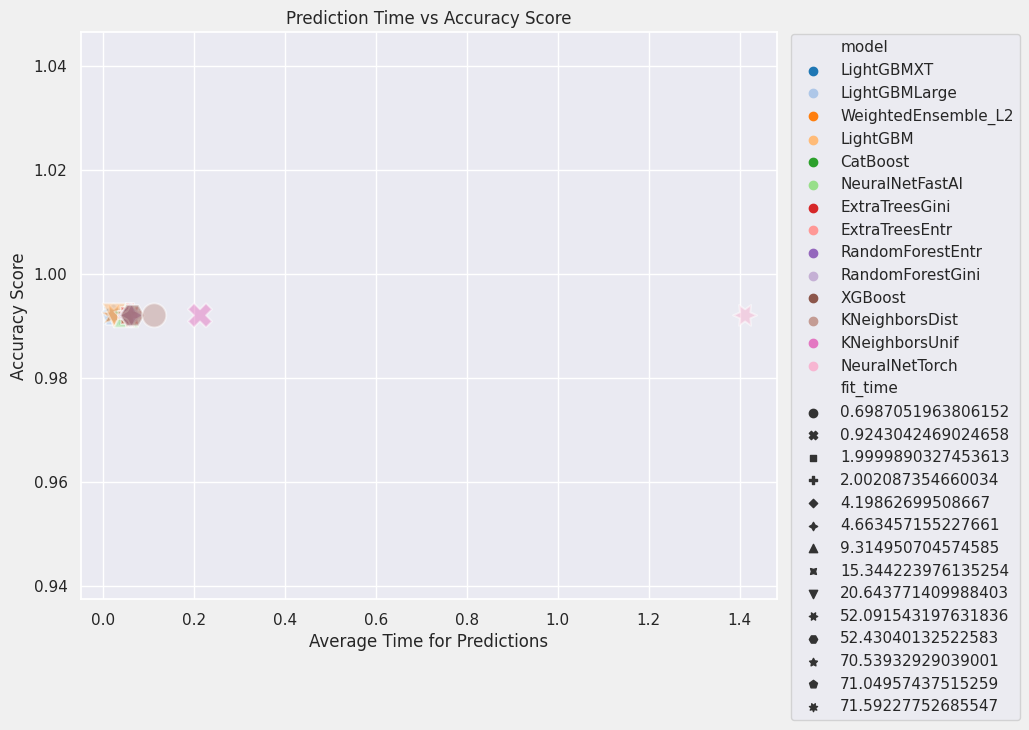

In [11]:
leaderboard=pd.DataFrame(predictor.leaderboard())

plt.figure(figsize=(8, 7))
sns.set(style='darkgrid')
sns.scatterplot(
    x='pred_time_val',
    y='score_val',
    data=leaderboard,
    s=300,
    alpha=0.5,
    hue='model',
    palette='tab20',
    style='fit_time'
)

plt.title('Prediction Time vs Accuracy Score')
plt.xlabel('Average Time for Predictions')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1.01,1.01))

plt.savefig('assets/Real_World_Model_to_Deployment_11.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_11.webp)

#### Model Evaluation

In [12]:
# load best model
predictor = TabularPredictor.load("model/")

In [13]:
data_test = TabularDataset('dataset/exoTest.csv')
# replacing label class [1,2] -> [0,1]
data_test = data_test.replace({'LABEL': {2:1, 1:0}})

Loaded data from: dataset/exoTest.csv | Columns = 3198 / 3198 | Rows = 570 -> 570


In [14]:
X_test = data_test.drop(columns=['LABEL'] )
y_test = data_test['LABEL']

In [15]:
y_pred = predictor.predict(X_test)

In [16]:
eval_metrics = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

# {
#     "accuracy": 0.9912280701754386,
#     "balanced_accuracy": 0.5000000000000001,
#     "mcc": 0.0,
#     "f1": 0.0,
#     "precision": 0.0,
#     "recall": 0.0
# }

/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluation: accuracy on test data: 0.9912280701754386
Evaluations on test data:
{
    "accuracy": 0.9912280701754386,
    "balanced_accuracy": 0.5000000000000001,
    "mcc": 0.0,
    "f1": 0.0,
    "precision": 0.0,
    "recall": 0.0
}


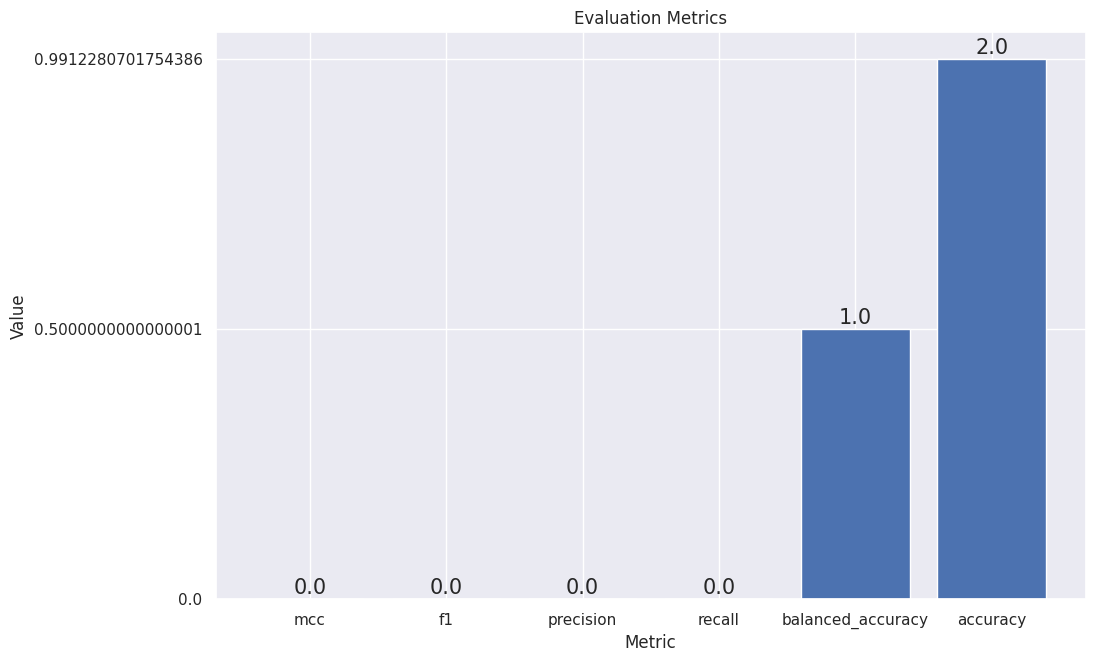

In [20]:
array = np.array(list(eval_metrics.items()))
df = pd.DataFrame(array, columns = ['metric','value']).sort_values(by='value')

fig, ax =  plt.subplots(figsize = (10, 7))
ax.bar(df['metric'], df['value'])
for bar in ax.patches:
    ax.annotate(text = bar.get_height(),
                  xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', 
                  va='center',
                  size=15,
                  xytext=(0, 8),
                  textcoords='offset points')
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title('Evaluation Metrics')
plt.ylim(bottom=0)

plt.savefig('assets/Real_World_Model_to_Deployment_12.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_12.webp)

### Tabular Data Predictor on the re-balanced Dataset

As expected the results are badly affected by the inbalance of the dataset. Let's see how AutoGluon handles a preprocessed dataset.

#### Data Preprocessing

In [30]:
df_train = pd.read_csv('dataset/exoTrain.csv')
df_test = pd.read_csv('dataset/exoTest.csv')

df_train = df_train.replace({'LABEL': {2:1, 1:0}})
df_test = df_test.replace({'LABEL': {2:1, 1:0}})

In [31]:
X_train = df_train.drop(['LABEL'], axis=1)
y_train = df_train['LABEL']

X_test = df_test.drop(['LABEL'], axis=1)
y_test = df_test['LABEL']

In [32]:
# normalizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [35]:
over_sampler = RandomOverSampler()
x_osample, y_osample = over_sampler.fit_resample(
    pd.DataFrame(X_train_scaled), y_train
)

In [38]:
df_merged_train = pd.concat([y_osample, x_osample], axis=1)
df_merged_train.head(5)

,LABEL,0,1,2,3,4,5,6,7,8,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,1,-0.002356,-0.002054,-0.005798,-0.008237,-0.008479,-0.011271,-0.010440,-0.009202,-0.009644,...,-0.014894,-0.016832,-0.017778,-0.014490,-0.012684,-0.010540,0.029934,0.034198,0.027368,0.018052
1,1,-0.008528,-0.007452,-0.009387,-0.008827,-0.010201,-0.009118,-0.008426,-0.008724,-0.009838,...,-0.012283,-0.014863,-0.016170,-0.015495,-0.013734,-0.012259,0.027075,0.031097,0.028039,0.022165
2,1,0.018049,0.018690,0.016731,0.015328,0.013010,0.013236,0.014403,0.016237,0.014920,...,-0.014671,-0.013581,-0.015124,-0.015595,-0.014049,-0.012178,0.027069,0.029101,0.022752,0.014100
3,1,0.008464,0.010040,0.007084,0.006386,0.007001,0.006876,0.008513,0.008593,0.009016,...,-0.011969,-0.014061,-0.015515,-0.014392,-0.013245,-0.012510,0.027239,0.029755,0.025989,0.021753
4,1,-0.058207,-0.056947,-0.057783,-0.056283,-0.052582,-0.049016,-0.046199,-0.049650,-0.052911,...,-0.032918,-0.025265,-0.024664,-0.022167,-0.022363,-0.020486,0.005329,0.009026,0.001748,-0.014525


In [40]:
df_merged_test = pd.concat([y_test, pd.DataFrame(X_test_scaled)], axis=1)
df_merged_test.head(5)

,LABEL,0,1,2,3,4,5,6,7,8,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,1,-0.031437,-0.050574,-0.035594,-0.054920,-0.038780,-0.054947,-0.040090,-0.057033,-0.038298,...,-0.004780,-0.030103,-0.007855,-0.031546,-0.009559,-0.025504,-0.024023,-0.009076,0.004709,-0.007866
1,1,0.414975,0.393434,0.413638,0.393701,0.410565,0.390216,0.410584,0.387450,0.409263,...,-0.067429,-0.134838,-0.139094,-0.198046,-0.200950,-0.243899,-0.269671,-0.262466,-0.265910,-0.223754
2,1,0.026154,0.006299,0.018946,-0.005135,0.005965,-0.018322,-0.006160,-0.028589,-0.022100,...,-0.004433,-0.037509,-0.014466,-0.037624,-0.019497,-0.048315,-0.037617,-0.030012,-0.027607,-0.010661
3,1,-0.106614,-0.124118,-0.109998,-0.125241,-0.102100,-0.120553,-0.105169,-0.117242,-0.096115,...,0.006545,-0.022406,0.000427,-0.024211,-0.009926,-0.028069,-0.025272,-0.025595,-0.050906,-0.036046
4,1,-0.044110,-0.059779,-0.043223,-0.059295,-0.043759,-0.059998,-0.041655,-0.061203,-0.039240,...,-0.010283,-0.038573,-0.012238,-0.033583,-0.014463,-0.039068,-0.036145,-0.019389,-0.031042,-0.015661


In [41]:
df_merged_train.to_csv('dataset/exoTrainNorm.csv')
df_merged_test.to_csv('dataset/exoTestNorm.csv')

#### Model Training

In [42]:
data = TabularDataset('dataset/exoTrainNorm.csv')

Loaded data from: dataset/exoTrainNorm.csv | Columns = 3199 / 3199 | Rows = 10100 -> 10100


In [43]:
print(len(data)*0.8)
# 8080.0

8080.0


In [44]:
train_size = 8080
train_data = data.sample(n=train_size, random_state=SEED)
test_data = data.drop(train_data.index)
print(len(train_data), len(test_data))
# 8080 2020

8080 2020


In [48]:
predictor = TabularPredictor(label='LABEL', path=MODEL_PATH)
predictor.fit(train_data)

# AutoGluon training complete, total runtime = 412.18s ... Best model: "WeightedEnsemble_L2"

	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "model/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue May 30 23:14:35 UTC 2023
Disk Space Avail:   63.62 GB / 500.10 GB (12.7%)
Train Data Rows:    8080
Train Data Columns: 3198
Label Column: LABEL
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using

In [49]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   1.000000       0.028167  93.416445                0.028167          93.416445            1       True         13
1              LightGBM   1.000000       0.031392  31.088042                0.031392          31.088042            1       True          4
2            LightGBMXT   1.000000       0.031414  37.281299                0.031414          37.281299            1       True          3
3              CatBoost   1.000000       0.047949  75.545099                0.047949          75.545099            1       True          7
4      RandomForestEntr   1.000000       0.062576   6.566619                0.062576           6.566619            1       True          6
5   WeightedEnsemble_L2   1.000000       0.063724   7.099042                0.001148           0.532423 

/home/xiaodie/.local/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 1.0,
  'KNeighborsDist': 1.0,
  'LightGBMXT': 1.0,
  'LightGBM': 1.0,
  'RandomForestGini': 1.0,
  'RandomForestEntr': 1.0,
  'CatBoost': 1.0,
  'ExtraTreesGini': 1.0,
  'ExtraTreesEntr': 1.0,
  'NeuralNetFastAI': 0.9925742574257426,
  'XGBoost': 1.0,
  'NeuralNetTorch': 1.0,
  'LightGBMLarge': 1.0,
  'WeightedEnsemble_L2': 1.0},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': 'model/models/KNeighborsUnif/',
  'KNeighborsDist': 'mod

|  | model | score_val | pred_time_val | fit_time |
| -- | -- | -- | -- | -- |
| 0 | LightGBM | 1.000000 | 0.029377 | 29.271464 |
|  1 | LightGBMLarge | 1.000000 | 0.037100 | 94.302897 |
|  2 | CatBoost | 1.000000 | 0.057690 | 79.490693 |
|  3 | ExtraTreesGini | 1.000000 | 0.063615 | 2.981032 |
|  4 | ExtraTreesEntr | 1.000000 | 0.064469 | 2.950440 |
|  5 | RandomForestGini | 1.000000 | 0.065542 | 6.167094 |
|  6 | WeightedEnsemble_L2 | 1.000000 | 0.065813 | 3.676120 |
|  7 | RandomForestEntr | 1.000000 | 0.067343 | 6.783359 |
|  8 | XGBoost | 1.000000 | 0.099369 | 74.019001 |
|  9 | NeuralNetTorch | 1.000000 | 1.658319 | 26.595248 |
|  10 | LightGBMXT | 0.997525 | 0.027803 | 28.317720 |
|  11 | KNeighborsDist | 0.997525 | 0.367821 | 1.086449 |
|  12 | KNeighborsUnif | 0.997525 | 0.436408 | 0.956370 |
|  13 | NeuralNetFastAI | 0.986386 | 0.074977 | 20.446434 |

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   1.000000       0.028167  93.416445                0.028167          93.416445            1       True         13
1              LightGBM   1.000000       0.031392  31.088042                0.031392          31.088042            1       True          4
2            LightGBMXT   1.000000       0.031414  37.281299                0.031414          37.281299            1       True          3
3              CatBoost   1.000000       0.047949  75.545099                0.047949          75.545099            1       True          7
4      RandomForestEntr   1.000000       0.062576   6.566619                0.062576           6.566619            1       True          6
5   WeightedEnsemble_L2   1.000000       0.063724   7.099042                0.001148           0.532423            2       True         14
6        ExtraTreesGini   1

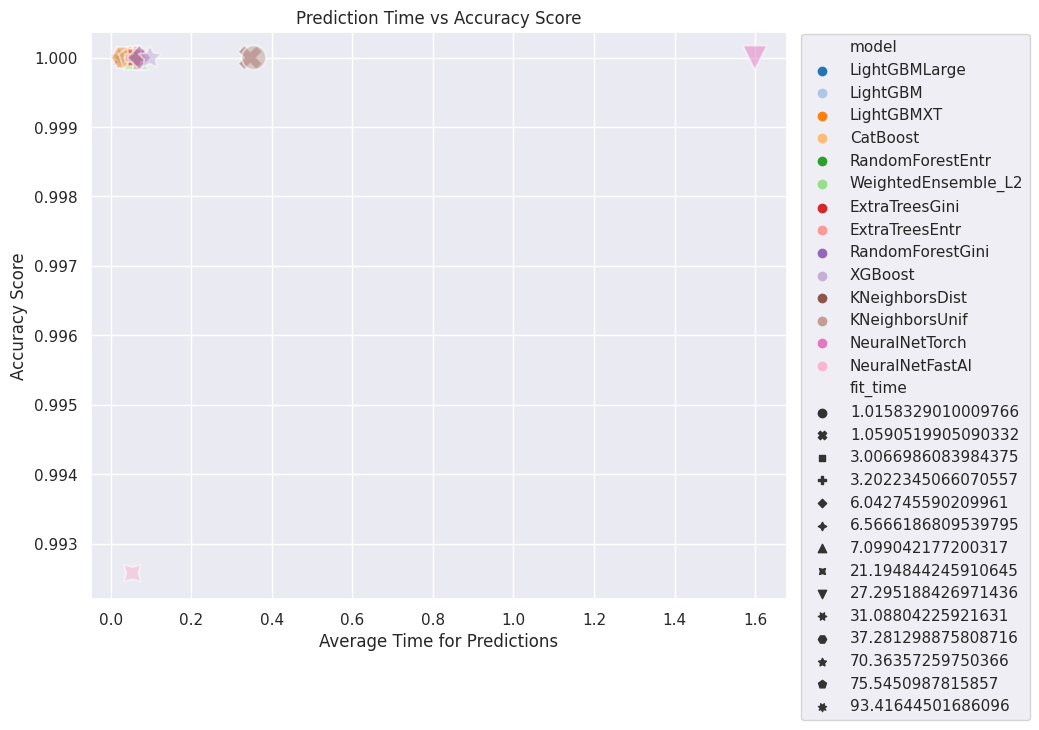

In [50]:
leaderboard=pd.DataFrame(predictor.leaderboard())

plt.figure(figsize=(8, 7))
sns.set(style='darkgrid')
sns.scatterplot(
    x='pred_time_val',
    y='score_val',
    data=leaderboard,
    s=300,
    alpha=0.5,
    hue='model',
    palette='tab20',
    style='fit_time'
)

plt.title('Prediction Time vs Accuracy Score')
plt.xlabel('Average Time for Predictions')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1.01,1.01))

plt.savefig('assets/Real_World_Model_to_Deployment_13.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_13.webp)

#### Model Evaluation

In [53]:
data_test = TabularDataset('dataset/exoTestNorm.csv')

Loaded data from: dataset/exoTestNorm.csv | Columns = 3199 / 3199 | Rows = 570 -> 570


In [54]:
X_test = data_test.drop(['LABEL'], axis=1)
y_test = data_test['LABEL']

In [51]:
# load best model
predictor = TabularPredictor.load("model/")

In [55]:
y_pred = predictor.predict(X_test)

In [56]:
eval_metrics = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

# {
#     "accuracy": 0.9912280701754386,
#     "balanced_accuracy": 0.5000000000000001,
#     "mcc": 0.0,
#     "f1": 0.0,
#     "precision": 0.0,
#     "recall": 0.0
# }

/home/xiaodie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluation: accuracy on test data: 0.9912280701754386
Evaluations on test data:
{
    "accuracy": 0.9912280701754386,
    "balanced_accuracy": 0.5000000000000001,
    "mcc": 0.0,
    "f1": 0.0,
    "precision": 0.0,
    "recall": 0.0
}


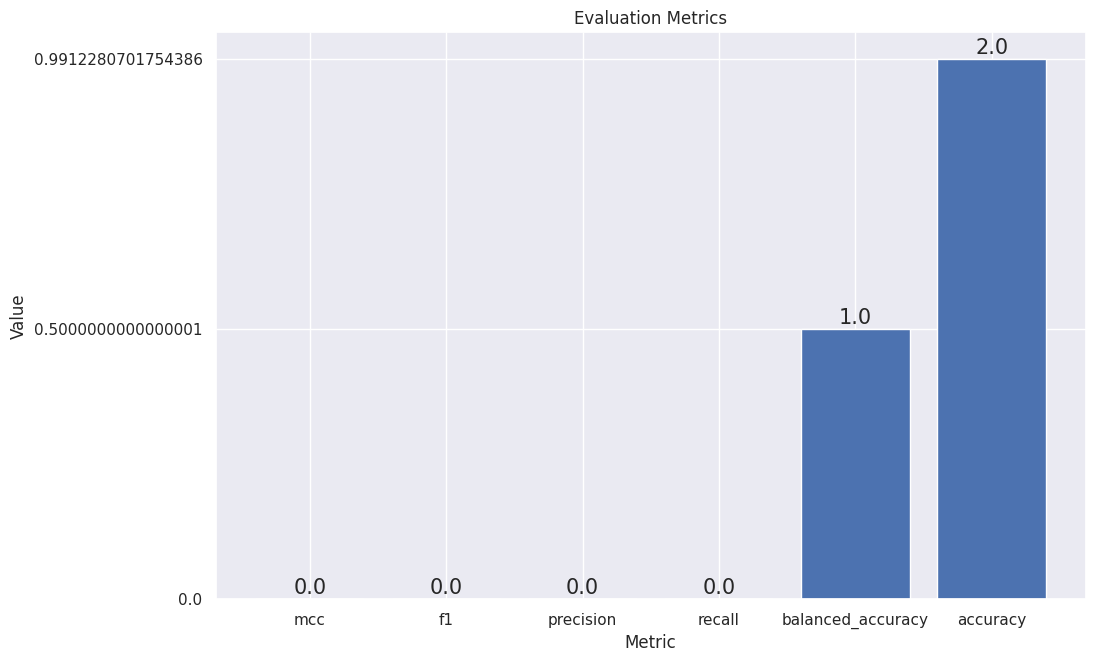

In [57]:
array = np.array(list(eval_metrics.items()))
df = pd.DataFrame(array, columns = ['metric','value']).sort_values(by='value')

fig, ax =  plt.subplots(figsize = (10, 7))
ax.bar(df['metric'], df['value'])
for bar in ax.patches:
    ax.annotate(text = bar.get_height(),
                  xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', 
                  va='center',
                  size=15,
                  xytext=(0, 8),
                  textcoords='offset points')
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title('Evaluation Metrics')
plt.ylim(bottom=0)

plt.savefig('assets/Real_World_Model_to_Deployment_14.webp', bbox_inches='tight')

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_14.webp)

### Multi Modal Predictor on the re-balanced Dataset

#### Data Preprocessing

In [3]:
data = TabularDataset('dataset/exoTrainNorm.csv')

In [4]:
train_data = data.sample(frac=0.8 , random_state=SEED)
test_data = data.drop(train_data.index)

#### Model Training

In [11]:
mm_predictor = MultiModalPredictor(label='LABEL', path=MODEL_PATH)

In [12]:
mm_predictor.fit(train_data)

AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.0.

- Pytorch version is 1.13.1+cu117.

- Model will be saved to "/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model".

- Validation metric is "roc_auc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

1 GPUs are detected, and 1 GPUs will 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 28: 'val_roc_auc' reached 0.92319 (best 0.92319), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=0-step=28.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 56: 'val_roc_auc' reached 0.98147 (best 0.98147), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=0-step=56.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 85: 'val_roc_auc' reached 0.98802 (best 0.98802), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=1-step=85.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 113: 'val_roc_auc' reached 0.98885 (best 0.98885), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=1-step=113.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 142: 'val_roc_auc' reached 0.98999 (best 0.98999), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=2-step=142.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 170: 'val_roc_auc' reached 0.99020 (best 0.99020), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=2-step=170.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 199: 'val_roc_auc' reached 0.99012 (best 0.99020), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=3-step=199.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 227: 'val_roc_auc' reached 0.99048 (best 0.99048), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=3-step=227.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 256: 'val_roc_auc' reached 0.99048 (best 0.99048), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=4-step=256.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 284: 'val_roc_auc' reached 0.99034 (best 0.99048), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=4-step=284.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 313: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 341: 'val_roc_auc' reached 0.99067 (best 0.99067), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=5-step=341.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 370: 'val_roc_auc' reached 0.99066 (best 0.99067), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=6-step=370.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 398: 'val_roc_auc' reached 0.99082 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=6-step=398.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 427: 'val_roc_auc' reached 0.99082 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=7-step=427.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 455: 'val_roc_auc' reached 0.99067 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=7-step=455.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 484: 'val_roc_auc' reached 0.99072 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=8-step=484.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 512: 'val_roc_auc' reached 0.99074 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=8-step=512.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 541: 'val_roc_auc' reached 0.99075 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=9-step=541.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 569: 'val_roc_auc' reached 0.99076 (best 0.99082), saving model to '/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model/epoch=9-step=569.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=10` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /run/media/xiaodie/dev/automl-gluon-tabular-data/05_Real_World_Model_to_Deployment/model
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_15.webp)

![Detection of Exoplanets using Transit Photometry](./assets/Real_World_Model_to_Deployment_16.webp)

#### Model Evaluation

In [ ]:
mm_predictor = MultiModalPredictor.load('model/')

In [18]:
data_test = TabularDataset('dataset/exoTestNorm.csv')
X_test = data_test.drop(['LABEL'], axis=1)
y_test = data_test['LABEL']

Loaded data from: dataset/exoTestNorm.csv | Columns = 3199 / 3199 | Rows = 570 -> 570


In [17]:
model_scoring = mm_predictor.evaluate(data_test, metrics=['acc', 'f1'])
print(model_scoring)
# {'acc': 0.987719298245614, 'f1': 0.0}

Predicting: 0it [00:00, ?it/s]

{'acc': 0.987719298245614, 'f1': 0.0}


In [40]:
data_test[2:8]
# check original dataframe to see labels - 3x1 and 3x0

,Unnamed: 0,LABEL,0,1,2,3,4,5,6,7,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
2,2,1,0.026154,0.006299,0.018946,-0.005135,0.005965,-0.018322,-0.006160,-0.028589,...,-0.004433,-0.037509,-0.014466,-0.037624,-0.019497,-0.048315,-0.037617,-0.030012,-0.027607,-0.010661
3,3,1,-0.106614,-0.124118,-0.109998,-0.125241,-0.102100,-0.120553,-0.105169,-0.117242,...,0.006545,-0.022406,0.000427,-0.024211,-0.009926,-0.028069,-0.025272,-0.025595,-0.050906,-0.036046
4,4,1,-0.044110,-0.059779,-0.043223,-0.059295,-0.043759,-0.059998,-0.041655,-0.061203,...,-0.010283,-0.038573,-0.012238,-0.033583,-0.014463,-0.039068,-0.036145,-0.019389,-0.031042,-0.015661
5,5,0,-0.039830,-0.057677,-0.041331,-0.057802,-0.041504,-0.057055,-0.040597,-0.057336,...,-0.005900,-0.032540,-0.009752,-0.031495,-0.011695,-0.030716,-0.027901,-0.012041,-0.023759,-0.014598
6,6,0,-0.052925,-0.069757,-0.055066,-0.073462,-0.055658,-0.071925,-0.054675,-0.070939,...,-0.005554,-0.031578,-0.010334,-0.035450,-0.014312,-0.031091,-0.029233,-0.013697,-0.025068,-0.014998
7,7,0,-0.041764,-0.059533,-0.043542,-0.059569,-0.043982,-0.059702,-0.043419,-0.059123,...,-0.004048,-0.028919,-0.006828,-0.027940,-0.007229,-0.026500,-0.031011,-0.016102,-0.027207,-0.015900


| | | LABEL | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | ... | 3187 | 3188 | 3189 | 3190 | 3191 | 3192 | 3193 | 3194 | 3195 | 3196 |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 2 | 2 | 1 | 0.026154 | 0.006299 | 0.018946 | -0.005135 | 0.005965 | -0.018322 | -0.006160 | -0.028589 | ... | -0.004433 | -0.037509 | -0.014466 | -0.037624 | -0.019497 | -0.048315 | -0.037617 | -0.030012 | -0.027607 | -0.010661 |
| 3 | 3 | 1 | -0.106614 | -0.124118 | -0.109998 | -0.125241 | -0.102100 | -0.120553 | -0.105169 | -0.117242 | ... | 0.006545 | -0.022406 | 0.000427 | -0.024211 | -0.009926 | -0.028069 | -0.025272 | -0.025595 | -0.050906 | -0.036046 |
| 4 | 4 | 1 | -0.044110 | -0.059779 | -0.043223 | -0.059295 | -0.043759 | -0.059998 | -0.041655 | -0.061203 | ... | -0.010283 | -0.038573 | -0.012238 | -0.033583 | -0.014463 | -0.039068 | -0.036145 | -0.019389 | -0.031042 | -0.015661 |
| 5 | 5 | 0 | -0.039830 | -0.057677 | -0.041331 | -0.057802 | -0.041504 | -0.057055 | -0.040597 | -0.057336 | ... | -0.005900 | -0.032540 | -0.009752 | -0.031495 | -0.011695 | -0.030716 | -0.027901 | -0.012041 | -0.023759 | -0.014598 |
| 6 | 6 | 0 | -0.052925 | -0.069757 | -0.055066 | -0.073462 | -0.055658 | -0.071925 | -0.054675 | -0.070939 | ... | -0.005554 | -0.031578 | -0.010334 | -0.035450 | -0.014312 | -0.031091 | -0.029233 | -0.013697 | -0.025068 | -0.014998 |
| 7 | 7 | 0 | -0.041764 | -0.059533 | -0.043542 | -0.059569 | -0.043982 | -0.059702 | -0.043419 | -0.059123 | ... | -0.004048 | -0.028919 | -0.006828 | -0.027940 | -0.007229 | -0.026500 | -0.031011 | -0.016102 | -0.027207 | -0.015900 |

In [42]:
# pick data without labels from test set
test_pred = X_test[2:8]

In [43]:
print(mm_predictor.class_labels)
mm_predictor.predict_proba(test_pred)

[0 1]


,0,1
2,0.990848,0.009152
3,0.873063,0.126937
4,0.989407,0.010593
5,0.993549,0.006451
6,0.983894,0.016106
7,0.993914,0.006086


|  | 0 | 1 |
| -- | -- | -- |
| 2 | 0.990848 | 0.009152 |
| 3 | 0.873063 | 0.126937 |
| 4 | 0.989407 | 0.010593 |
| 5 | 0.993549 | 0.006451 |
| 6 | 0.983894 | 0.016106 |
| 7 | 0.993914 | 0.006086 |

Hmmmm so why doesn't this work?